
We begin this class by looking at a **simplified** problem in *predictive science*.  
We are given a long, thin rod, kept at 0 degrees at both ends, which is suddenly exposed to
a heat souce(a flame) at one end. Our goal is to predict the *average heat flux* near the other 
end of the rod after a few minutes(t=100).  

The scenario is (approximately) modelled by the heat equation with a source, namely:
$$u_t -(\alpha(x)u_x)_x=100/465 e^{-50(x-\beta)^2}, \quad u(0,t)=u(1,t)=0 \quad  u(x,t=0)=0.$$

The average heat flux on (.9,1) at $t=100$ is given by 
$$10 \int_{.9}^{.1} \alpha(x)u_x(x,t=100) \; dx $$


However, our task is complicated by the fact that certain properties of the prediction scenario
are only *approximately known*: 

1. The thermal diffusivity $\alpha$ of the rod is only approximately known-it is given by a Maxwellian distribution with maximum value of $7.0\times 10^{-5}$.
2. The location of the heat source center $\beta$ (a bell curve profile with maximum 100/465) is given by a Normal(Gaussian) distribution with mean 0 and standard deviation .2

The classical method for solving this problem is via sampling:
1. We sample $\alpha$ and $\beta$ from the corresponding 
distributions, 
2. Solve the resulting deterministic heat equation from t=0 to t=100.
3. Compute the average heat flux near the right end of the rod.

If we draw enough samples, we'll get a reasonable representation of the probability density function(pdf) of the 
heat flux and be able to make a quantitative prediction of the heat flux.

Within steps 1, 2, and 3, there are many aspects of the topics we'll study this semester.  Let's look at the Python code *intro.py* to solve this problem and its relation to some of the algorithms will cover in this course.



In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

/Users/Undertrick/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


* In python, we import various libraries so we can access their data structions, functions, and capabilities.
* Howevery, typing out the full library name to call a subfunction is tedious so the __as__ assignes the library (or sublibary) a short name.

We're just going to step through the workflow once (Samples=1).  The "outer loop" (repeating the workflow for each sample) would typically be called a large number of times. We create an array, heat_flux, for storing the heat flux sample results.


In [2]:
Samples=1
alpha_samples=3.76E-5*stat.maxwell.rvs(size=Samples)
heat_flux=np.zeros(Samples)
beta_samples=stat.norm.rvs(0,.2,size=Samples)
for loop in xrange(Samples):
    alpha=alpha_samples[loop] 
    beta=beta_samples[loop]

Our approach to solving the PDE is to **discretize** it at a set number of spatial points using the **finite difference method** and then use a **time-marching** algorithm (also based on finite differences) to evolve our discrete set of points from $t=0$ to $t=100$.  

* We start by creating an equispaced set of points between 0 and 1, .05 apart. The distance between data points is often called the grid size (or mesh size)  and is often written as $h$. 
* Our timesteps(think solution *snapshots*) will be 1 time unit apart.

In [3]:
    gridsize=np.float(.05)
    timestep=1
    steps=100
    points=np.int(1/.025)+1
    x=np.linspace(0,1,num=points)

We now build a numpy array to contain the solution temperature T over the timsteps. Default data type is 64bit float.

Note that the initial state of the rod is zero temperature. 

In [4]:
    U=np.zeros([points,steps+1])

We rewrite the heat equation as $u_t=\alpha u_{xx}+100e^{-(x-\beta)^2}$ and replace $u_{xx}$ with the *central finite difference* approximation 
$$ u_{xx}(x,t) = \frac{-2u(x,t)+u(x+h,t)+u(x-h,t)}{h^2} $$ 

Note that this approximation only involves the current time level-so we can rewrite it as a matrix $A$ operating on the vector of temperatures at a specific time, $\alpha A u|_{t}$.  

Also, the forcing term $f$ is also time-independant; so we will compute the matrix $A$ and vector $f$ once and store them before we start *time-stepping* or *time-marching*


In [5]:
    A=-2*np.diagflat(np.ones(points-2))+np.diagflat(np.ones(points-3),-1)+np.diagflat(np.ones(points-3),1)
    f=np.float(100)/np.float(465)*np.exp(-50*(x-beta)**2)

We now begin timestepping to t=100.  Our time marching scheme is the implicit Euler method, which replaces the time derivative with a forward difference in time($(f(t+\delta t)-f(t))/(\delta t)$) and evaluates the right-hand-side $F(u,u_x,u_{xx},t)$ at time $t+\delta t$.  With this substitution, our equation becomes
$$
U(t+\delta t)=\delta t(\alpha A U(t+\delta t)+f)+U(t)
$$ 
Regrouping, we have 
$$
(I-\delta t \alpha A)U(t+\delta t)=\delta t f + U(t)
$$
We have now changed our PDE into a linear algebra problem where the previous state and the forcing source gives the data for a linear alebra problem of the type $Bu=c$.

Note that the "B" matrix in this problem does not change from timestep to timestep (as $\delta t$) is fixed, so we first precompute it.

In [6]:
    B=np.diagflat(np.ones(points-2))-(timestep*alpha/gridsize**2)*A    

We now solve the system from t=0 to t=10, using Gaussian Elimination (np.linalg.solve) to determine $U(t+\delta t)$

In [7]:
    for timeloop in xrange(steps):
        data=timestep*f+U[:,timeloop]
        U[1:points-1,timeloop+1]=np.linalg.solve(B,data[1:points-1])

Now that we have the system solution, we can *postprocess* the temperature to obtain the heat flux. However, we are computing an integral and we only have grid values at $T=100$.  
* We can **Interpolate** the solution between grid points.  Here we will treat the function as *linear* between grid points.
* In this case we *could* do the resulting heat flux integral exactly,  but in general we will have to use **Numerical Quadrature** to evaluate the heat flux integral. Here we use the *centroid rule* to integrate from grid point i to grid point i+1, yielding 
$$
\int_{x_i}^{x_{i+1}} \alpha T_x \; dx = h \alpha T_x(i+1/2)
$$

As we have assumed that the temperature is linear between grid points, we know that the derivative does not change
between grid points and can be determined by differencing $U(x_{i+1})$ and $U(x_i)$.



In [8]:
    heat_flux[loop]=10*gridsize*alpha*(U[17,steps-1]-U[16,steps-1])/(2*gridsize) #first interval
    heat_flux[loop]+=10*gridsize*alpha*(U[18,steps-1]-U[17,steps-1])/(2*gridsize) #second interval 



We can also do some plotting at this point; here we'll plot the temperature U as a function of position and time in 
3D surface plot, interpolating linearly between points. 

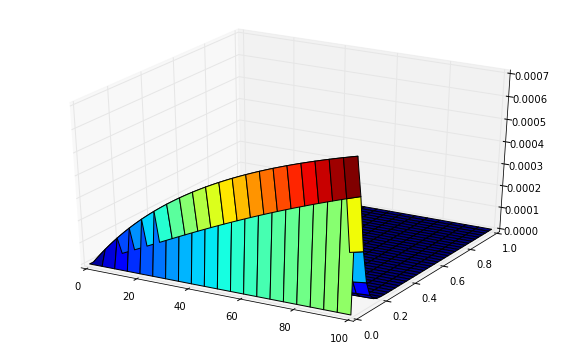

In [9]:
    X,Y=np.meshgrid(np.linspace(0,100,num=steps+1),x)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,U,rstride=1,cstride=5,cmap=cm.jet)
    plt.show()


If we now build a histogram from our sampled heat flux values, we can approximate the PDF of the heat flux.

Here's a histogram of the -log of the heat flux.

<img src="flux_hist.png">

While this demo workflow for uncertainty quantification of a prediction is interesting, there are **many** unanswered questions:

1. What is the effect of arithmetic operations performed with finite precision(in this case, 64-bit) on my prediction?
2. What was the effect of using Gaussian Elimination to solve my linear system at each timestep?
3. What was the effect of the timestep size (and the method) on my accuracy?
4. What was the effect of the gridsize (*the spatial discretization*) on my accuracy?
5. Was my choice of linear interpolation for computing the heat flux reasonable and accurate?
6. What was the effect of using numerical quadrature to compute my *Quantity of Interest*(QoI)-the heat flux?
7. *What was the effect of finite sampling on my predicted PDF for the heat flux?*-NOT COVERED
8. I made several choices behind the scenes in developing my numerical model-is it a reasonable representation of reality?

* 1-6 are classical aspects of solution **verification**, an important part of computational science.
* 7-8 are aspects of model **validation**, and would be covered by courses in probabalistic and mathematical modelling.

In this class, we will develop a detailed undestanding of the answers to these questions by studying many properties of numerical algorithms, among them
* Accuracy
* Stability
* Operational Cost
        1. CPU time
        2. Memory Requirements
